In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
dschettler8845_brats_2021_task1_path = kagglehub.dataset_download('dschettler8845/brats-2021-task1')

print('Data source import complete.')


Using Colab cache for faster access to the 'brats-2021-task1' dataset.
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brats-2021-task1/BraTS2021_00495.tar
/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar
/kaggle/input/brats-2021-task1/BraTS2021_00621.tar


In [3]:
!pip install nibabel

In [4]:
!pip install torch

In [ ]:
import os
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class BraTSDataset(Dataset):
    def __init__(self, patient_ids, root_dir, transform=None):
        self.patient_ids = patient_ids
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        p_id = self.patient_ids[idx]
        p_path = os.path.join(self.root_dir, p_id)

        # 1. Load the 4 modalities (FLAIR, T1, T1ce, T2)
        # We use nib.load().get_fdata() to get the 3D numpy array
        modalities = []
        for mod in ['flair', 't1', 't1ce', 't2']:
            file_path = os.path.join(p_path, f"{p_id}_{mod}.nii.gz")
            img = nib.load(file_path).get_fdata()
            # Use the preprocessing function we wrote earlier
            img = preprocess_volume(img, is_mask=False)
            img = normalize(img) # Normalize to mean 0, std 1
            modalities.append(img)

        # 2. Load the Segmentation Mask
        mask_path = os.path.join(p_path, f"{p_id}_seg.nii.gz")
        mask = nib.load(mask_path).get_fdata()
        mask = preprocess_volume(mask, is_mask=True)

        # --- IMPORTANT: REMAP LABEL 4 TO 3 ---
        mask[mask == 4] = 3

        # 3. Stack modalities into 4 Channels (C, H, W, D)
        image_stack = np.stack(modalities, axis=0) # Result: (4, 128, 128, 128)

        return torch.from_numpy(image_stack).float(), torch.from_numpy(mask).long()

In [ ]:
# 1. Get list of all patient folder names
data_path = "/kaggle/input/brats-2021-task1/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16112021"
all_patient_ids = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

# 2. Split into Train (80%) and Validation (20%)
train_ids, val_ids = train_test_split(all_patient_ids, test_size=0.2, random_state=42)

# 3. Create Dataset objects
train_ds = BraTSDataset(train_ids, data_path)
val_ds   = BraTSDataset(val_ids, data_path)

# 4. Create DataLoaders
# Batch size is 1 because 3D MRI data is very heavy for GPU memory!
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

print(f"Total Patients: {len(all_patient_ids)}")
print(f"Training on: {len(train_loader)} patients")
print(f"Validating on: {len(val_loader)} patients")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/brats-2021-task1/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16112021'

In [ ]:
import os

# This lists everything in the input folder
for root, dirs, files in os.walk('/kaggle/input'):
    # We only want to see the first few folders to find the training data
    if len(dirs) > 0:
        print(f"Searching in: {root}")
        print(f"Found folders: {dirs[:5]}") # Shows first 5 folders
        break

Searching in: /kaggle/input
Found folders: ['brats-2021-task1']


In [ ]:
# Try this shorter path first
data_path = "/kaggle/input/brats-2021-task1"

# Or if there is a subfolder, it might look like this:
# data_path = "/kaggle/input/brats-2021-task1/BraTS2021_Training_Data"

# Check if it exists before proceeding
if os.path.exists(data_path):
    all_patient_ids = [d for d in os.listdir(data_path)
                       if os.path.isdir(os.path.join(data_path, d))
                       and d.startswith('BraTS2021')]
    print(f"Success! Found {len(all_patient_ids)} patients.")
else:
    print("Path still not found. Please check the 'Data' tab on the right side of Kaggle.")

Success! Found 0 patients.


In [ ]:
import os

def find_training_data(root_path='/kaggle/input'):
    for root, dirs, files in os.walk(root_path):
        # Check if any .nii.gz files exist in this folder
        if any(f.endswith('.nii.gz') for f in files):
            print(f"FOUND DATA AT: {root}")
            return root
        # Also check for .tar files (meaning data needs extraction)
        if any(f.endswith('.tar') for f in files):
            print(f"FOUND COMPRESSED DATA (.tar) AT: {root}")
            print(f"Compressed files found: {[f for f in files if f.endswith('.tar')]}")
    return None

actual_path = find_training_data()

FOUND COMPRESSED DATA (.tar) AT: /kaggle/input/brats-2021-task1
Compressed files found: ['BraTS2021_00495.tar', 'BraTS2021_Training_Data.tar', 'BraTS2021_00621.tar']


In [ ]:
import tarfile
import os

# Define paths
tar_path = '/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar'
extract_path = '/kaggle/working/BraTS2021_Training_Data'

# Create the folder if it doesn't exist
if not os.path.exists(extract_path):
    os.makedirs(extract_path)
    print("Extracting 12GB dataset... Please wait (5-10 mins).")
    with tarfile.open(tar_path) as tar:
        tar.extractall(path=extract_path)
    print("Extraction Complete!")
else:
    print("Data already extracted.")

Extracting 12GB dataset... Please wait (5-10 mins).


/tmp/ipython-input-937112840.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_path)


Extraction Complete!


In [ ]:
# The actual data is often nested one level deeper after extraction
# Let's find exactly where the BraTS2021_XXXXX folders are
all_patient_ids = []
for root, dirs, files in os.walk(extract_path):
    # Look for folders starting with BraTS2021
    patients = [d for d in dirs if d.startswith('BraTS2021')]
    if patients:
        data_path = root # This is our final data_path
        all_patient_ids = patients
        break

print(f"Success! Found {len(all_patient_ids)} patients at: {data_path}")

Success! Found 1251 patients at: /kaggle/working/BraTS2021_Training_Data


In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Split into training and validation
train_ids, val_ids = train_test_split(all_patient_ids, test_size=0.2, random_state=42)

# Initialize the Dataset (using the class we wrote earlier)
train_ds = BraTSDataset(train_ids, data_path)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)

print("DataLoader is ready for training!")

DataLoader is ready for training!


In [ ]:
import numpy as np
from skimage.transform import resize

def preprocess_volume(img_volume, is_mask=False):
    """Crops 240x240 to 160x160 and resizes depth to 128."""
    # 1. Center Crop
    start_x = (240 - 160) // 2
    start_y = (240 - 160) // 2
    cropped_vol = img_volume[start_x:start_x+160, start_y:start_y+160, :]

    # 2. Resize Depth and maintain labels if it's a mask
    order = 0 if is_mask else 1
    final_vol = resize(cropped_vol, (128, 128, 128),
                       order=order,
                       preserve_range=True,
                       anti_aliasing=not is_mask)

    # 3. Handle BraTS Label Quirk (Change label 4 to 3)
    if is_mask:
        final_vol[final_vol == 4] = 3

    return final_vol

def normalize(data):
    """Z-score normalization: Mean 0, Std 1."""
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / (std + 1e-8)

In [ ]:
import os
import nibabel as nib
import torch
from torch.utils.data import Dataset, DataLoader

class BraTSDataset(Dataset):
    def __init__(self, patient_ids, root_dir):
        self.patient_ids = patient_ids
        self.root_dir = root_dir

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        p_id = self.patient_ids[idx]
        p_path = os.path.join(self.root_dir, p_id)

        # Load and preprocess all 4 modalities
        channels = []
        for mod in ['flair', 't1', 't1ce', 't2']:
            img = nib.load(os.path.join(p_path, f"{p_id}_{mod}.nii.gz")).get_fdata()
            channels.append(normalize(preprocess_volume(img, is_mask=False)))

        # Load and preprocess mask
        mask = nib.load(os.path.join(p_path, f"{p_id}_seg.nii.gz")).get_fdata()
        mask = preprocess_volume(mask, is_mask=True)

        # Stack into (4, 128, 128, 128) and convert to tensors
        image_stack = np.stack(channels, axis=0)
        return torch.from_numpy(image_stack).float(), torch.from_numpy(mask).long()

# Usage:
# train_loader = DataLoader(BraTSDataset(train_ids, data_path), batch_size=1, shuffle=True)

In [ ]:
import torch
import torch.nn as nn

def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm3d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm3d(out_channels),
        nn.ReLU(inplace=True)
    )

class UNet3D(nn.Module):
    def __init__(self, in_channels=4, out_classes=4):
        super(UNet3D, self).__init__()

        # --- Encoder (Contracting Path) ---
        self.enc1 = conv_block(in_channels, 32)
        self.enc2 = conv_block(32, 64)
        self.enc3 = conv_block(64, 128)
        self.enc4 = conv_block(128, 256)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        # --- Bottleneck ---
        self.bottleneck = conv_block(256, 512)

        # --- Decoder (Expanding Path + Skip Connections) ---
        self.up4 = nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2)
        self.dec4 = conv_block(512, 256) # (up4 output 256 + enc4 skip 256 = 512)

        self.up3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.dec3 = conv_block(256, 128) # (up3 output 128 + enc3 skip 128 = 256)

        self.up2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.dec2 = conv_block(128, 64)  # (up2 output 64 + enc2 skip 64 = 128)

        self.up1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.dec1 = conv_block(64, 32)   # (up1 output 32 + enc1 skip 32 = 64)

        # --- Final Output Layer ---
        self.final = nn.Conv3d(32, out_classes, kernel_size=1)

    def forward(self, x):
        # Encoder Path
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder Path with Skip Connections (torch.cat)
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final(d1)

# Initialize model
model = UNet3D(in_channels=4, out_classes=4)

In [ ]:
def dice_loss(pred, target, num_classes=4):
    smooth = 1e-6
    # One-hot encoding handles the multiple tumor classes
    target_one_hot = torch.eye(num_classes)[target].permute(0, 4, 1, 2, 3).to(pred.device)
    pred_soft = torch.softmax(pred, dim=1)

    intersection = (pred_soft * target_one_hot).sum(dim=(2, 3, 4))
    union = pred_soft.sum(dim=(2, 3, 4)) + target_one_hot.sum(dim=(2, 3, 4))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def train_model(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Run for 1 epoch
loss = train_model(model, train_loader, optimizer, device)
print(f"Epoch Finished. Average Dice Loss: {loss:.4f}")

RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)

In [ ]:
from tqdm import tqdm # Import the progress bar library

def train_model(model, loader, optimizer, device):
    model.train()
    total_loss = 0

    # Wrap the loader in tqdm to create the progress bar
    # 'desc' sets the label, 'unit' sets the label for each step
    progress_bar = tqdm(enumerate(loader), total=len(loader), desc="Training", unit="batch")

    for batch_idx, (images, masks) in progress_bar:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        current_loss = loss.item()
        total_loss += current_loss

        # Update the progress bar text with the current loss
        progress_bar.set_postfix({"loss": f"{current_loss:.4f}"})

    return total_loss / len(loader)

In [ ]:
# 1. Setup Device and Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D(in_channels=4, out_classes=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 2. Run for multiple epochs
num_epochs = 10
for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")
    avg_loss = train_model(model, train_loader, optimizer, device)
    print(f"Epoch {epoch+1} Average Dice Loss: {avg_loss:.4f}")

    # Save the model so you don't lose progress
    torch.save(model.state_dict(), f"brats_unet_epoch_{epoch+1}.pth")

Extracting dataset... this may take a few minutes.


/tmp/ipython-input-3254418309.py:25: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=EXTRACT_PATH)


Extraction Complete!


Epoch 1/2: 100%|██████████| 1000/1000 [45:47<00:00,  2.75s/it, Dice Loss=0.6523]


Epoch 1 Avg Loss: 0.7299


Epoch 2/2: 100%|██████████| 1000/1000 [45:35<00:00,  2.74s/it, Dice Loss=0.3442]


Epoch 2 Avg Loss: 0.4417

--- Starting Evaluation ---


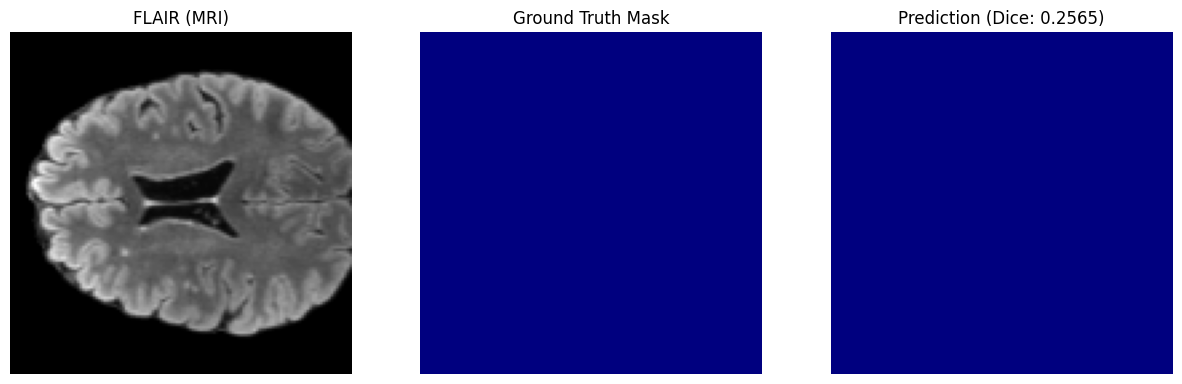

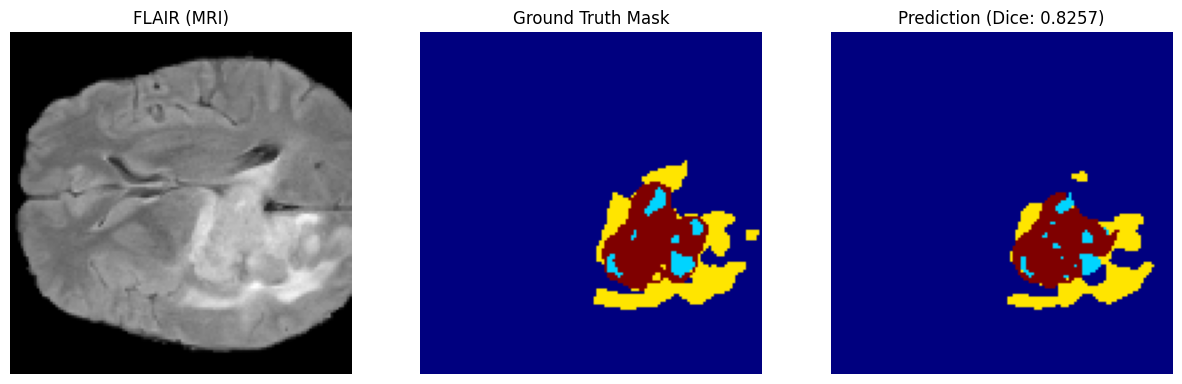

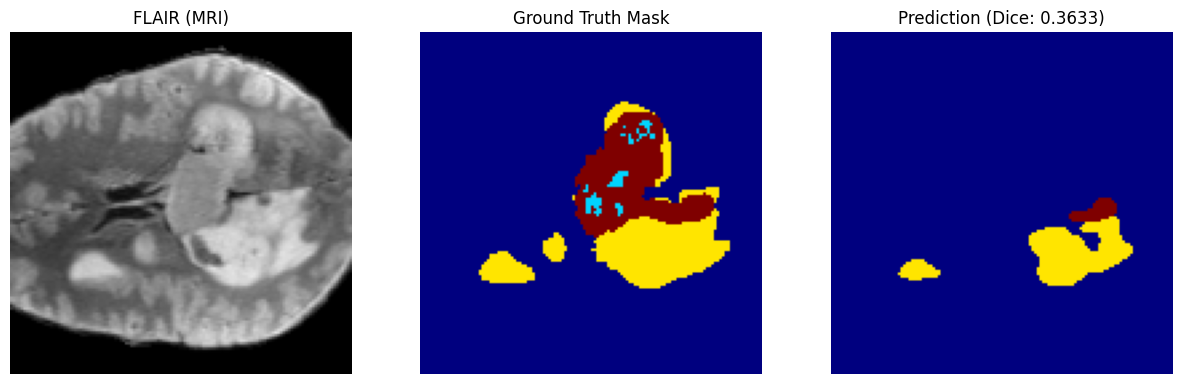

Average Dice Score on Validation Set: 0.5570


In [5]:
import os
import tarfile
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tqdm import tqdm

# --- 1. CONFIGURATION & PATHS ---
DATA_TAR_PATH = '/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar'
EXTRACT_PATH = '/kaggle/working/BraTS2021_Training_Data'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 1 # 3D MRI is memory intensive
NUM_EPOCHS = 2
LEARNING_RATE = 1e-4

# --- 2. DATA EXTRACTION ---
if not os.path.exists(EXTRACT_PATH):
    os.makedirs(EXTRACT_PATH)
    print("Extracting dataset... this may take a few minutes.")
    with tarfile.open(DATA_TAR_PATH) as tar:
        tar.extractall(path=EXTRACT_PATH)
    print("Extraction Complete!")

# Locate the actual folder containing patient IDs
data_dir = EXTRACT_PATH
all_patient_ids = [d for d in os.listdir(data_dir) if d.startswith('BraTS2021')]
train_ids, val_ids = train_test_split(all_patient_ids, test_size=0.2, random_state=42)

# --- 3. PREPROCESSING HELPER FUNCTIONS ---
def preprocess_volume(img_volume, is_mask=False):
    """Crops to 160x160 and resizes depth to 128."""
    # Center Crop (240x240 -> 160x160)
    start_x = (240 - 160) // 2
    start_y = (240 - 160) // 2
    cropped_vol = img_volume[start_x:start_x+160, start_y:start_y+160, :]

    # Resize to 128x128x128
    order = 0 if is_mask else 1
    final_vol = resize(cropped_vol, (128, 128, 128), order=order,
                       preserve_range=True, anti_aliasing=not is_mask)

    if is_mask:
        final_vol = final_vol.astype(np.uint8)
        final_vol[final_vol == 4] = 3 # Remap label 4 to 3
    return final_vol

def normalize(data):
    """Z-score normalization."""
    return (data - np.mean(data)) / (np.std(data) + 1e-8)

# --- 4. DATASET & DATALOADER ---
class BraTSDataset(Dataset):
    def __init__(self, patient_ids, root_dir):
        self.patient_ids = patient_ids
        self.root_dir = root_dir

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        p_id = self.patient_ids[idx]
        p_path = os.path.join(self.root_dir, p_id)

        # Load 4 Modalities
        modalities = []
        for mod in ['flair', 't1', 't1ce', 't2']:
            img = nib.load(os.path.join(p_path, f"{p_id}_{mod}.nii.gz")).get_fdata()
            modalities.append(normalize(preprocess_volume(img, is_mask=False)))

        # Load Mask
        mask = nib.load(os.path.join(p_path, f"{p_id}_seg.nii.gz")).get_fdata()
        mask = preprocess_volume(mask, is_mask=True)

        return torch.tensor(np.stack(modalities, axis=0)).float(), torch.tensor(mask).long()

train_loader = DataLoader(BraTSDataset(train_ids, data_dir), batch_size=BATCH_SIZE, shuffle=True)

# --- 5. 3D U-NET MODEL ---
def conv_block(in_c, out_c):
    return nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=3, padding=1),
        nn.BatchNorm3d(out_c), nn.ReLU(inplace=True),
        nn.Conv3d(out_c, out_c, kernel_size=3, padding=1),
        nn.BatchNorm3d(out_c), nn.ReLU(inplace=True)
    )

class UNet3D(nn.Module):
    def __init__(self, in_channels=4, out_classes=4):
        super().__init__()
        self.enc1 = conv_block(in_channels, 32)
        self.enc2 = conv_block(32, 64)
        self.enc3 = conv_block(64, 128)
        self.pool = nn.MaxPool3d(2)
        self.bottleneck = conv_block(128, 256)
        self.up3 = nn.ConvTranspose3d(256, 128, 2, 2)
        self.dec3 = conv_block(256, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, 2)
        self.dec2 = conv_block(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, 2)
        self.dec1 = conv_block(64, 32)
        self.final = nn.Conv3d(32, out_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b  = self.bottleneck(self.pool(e3))
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.final(d1)

# --- 6. LOSS & TRAINING LOOP ---
def dice_loss(pred, target, num_classes=4):
    smooth = 1e-6
    target_one_hot = torch.eye(num_classes, device=pred.device)[target].permute(0, 4, 1, 2, 3)
    pred_soft = torch.softmax(pred, dim=1)
    intersection = (pred_soft * target_one_hot).sum(dim=(2, 3, 4))
    union = pred_soft.sum(dim=(2, 3, 4)) + target_one_hot.sum(dim=(2, 3, 4))
    return 1 - ((2. * intersection + smooth) / (union + smooth)).mean()

model = UNet3D().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for images, masks in pbar:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({"Dice Loss": f"{loss.item():.4f}"})

    torch.save(model.state_dict(), f"brats_unet_v1_epoch{epoch+1}.pth")
    print(f"Epoch {epoch+1} Avg Loss: {total_loss/len(train_loader):.4f}")
import matplotlib.pyplot as plt

def evaluate_and_visualize(model, val_ids, root_dir, device, num_samples=1):
    model.eval()
    val_dataset = BraTSDataset(val_ids, root_dir)
    # Using batch_size=1 for testing to avoid memory issues
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

    total_dice = 0

    print("\n--- Starting Evaluation ---")
    with torch.no_grad():
        for i, (images, masks) in enumerate(val_loader):
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate Dice for this batch
            loss = dice_loss(outputs, masks)
            dice_score = 1 - loss.item()
            total_dice += dice_score

            # Visualize the first 'num_samples'
            if i < num_samples:
                # Convert output to discrete labels
                preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1).cpu().numpy()
                true_mask = masks.cpu().numpy()
                img_slice = images.cpu().numpy()

                # Choose the middle slice of the volume (index 64)
                z_slice = 64

                plt.figure(figsize=(15, 5))

                # Modality 1 (FLAIR)
                plt.subplot(1, 3, 1)
                plt.title("FLAIR (MRI)")
                plt.imshow(img_slice[0, 0, :, :, z_slice], cmap='gray')
                plt.axis('off')

                # Ground Truth
                plt.subplot(1, 3, 2)
                plt.title("Ground Truth Mask")
                plt.imshow(true_mask[0, :, :, z_slice], cmap='jet')
                plt.axis('off')

                # Prediction
                plt.subplot(1, 3, 3)
                plt.title(f"Prediction (Dice: {dice_score:.4f})")
                plt.imshow(preds[0, :, :, z_slice], cmap='jet')
                plt.axis('off')

                plt.show()

            if i == 10: # Limit evaluation to 10 samples for speed, or remove this
                break

    avg_dice = total_dice / min(len(val_loader), 11)
    print(f"Average Dice Score on Validation Set: {avg_dice:.4f}")

# --- EXECUTE TESTING ---
# Load the best weights saved during training
# model.load_state_dict(torch.load('brats_unet_v1_epoch2.pth'))

evaluate_and_visualize(model, val_ids, data_dir, DEVICE, num_samples=3)
